# Techniques for Calculating the Efficient Frontier

In [70]:
import sys
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

sys.path.insert(0, os.path.abspath('../../../src/mpt/efficient_frontier'))
sys.path.insert(1, os.path.abspath('../../../src/mpt/utils'))

In [71]:
import importlib
importlib.reload(sys.modules['EfficientFrontier'])

<module 'EfficientFrontier' from '/Users/michael/UCL/Disertation/porfolio-optimisation/src/mpt/efficient_frontier/EfficientFrontier.py'>

In [72]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])

from EfficientFrontier import EfficientFrontier

Throughout this note book we will use the following data taken from chapter 6 of Modern Portfolio Theory and Investment Analysis. 

In [73]:
μ = np.array([14., 8., 20.])

Σ = np.array([
    [6*6.,     0.5*6*3., 0.2*6*15.],
    [0.5*6*3., 3*3.,      0.4*3*15.],
    [0.2*6*15., 0.4*3*15., 15*15.]
])

R_f = 5
stds = [6, 3, 15]

In [74]:
Σ

array([[ 36.,   9.,  18.],
       [  9.,   9.,  18.],
       [ 18.,  18., 225.]])

## Short Sales Allowed with Riskless Lending and Borrowing

There is a single portfolio in return volatility space that is prefered to all other portfolios. The portfolio plots the ray connecting the riskless asset and a risky portfolio.

The tangency portfolio maximises the excess return to the volatility of the portfolio/the ray that maximises the slope.

**Maximise**

$$ \frac{x^T\mu - r_f}{\sqrt{x^T\Sigma x}} $$

**Subject to**

$$ \sum_{i=1}^N x_i = 1$$

We can simplify the calculation by substituting the constraint into the objective function by noting that

$$ r_f = \sum_{i=1}^{N} x_i r_f$$

leading to a transformed objective function 

$$ \frac{\sum_{i=1}^{N} x_i (\mu_i - r_f)}{\sum_{i=1}^Nx_i^2 \sigma_i^2 + \sum_{i=1}^{N}\sum_{j=1,j\neq i}^N x_i x_j \sigma_{ij}}   $$

To solve this we take the partial derivative with respect to each investment weight and solve the following system of linear equations (for our three asset example).

$$\begin{bmatrix}
    \mu_1 - r_f \\      
    \mu_2 - r_f \\       
    \mu_3 - r_f 
\end{bmatrix}=
\begin{bmatrix}
    \sigma_{1}^2 & \sigma_{12}      & \sigma_{13}  \\
    \sigma_{12} & \sigma_{2}^2 & \sigma_{23}  \\
    \sigma_{13}       &  \sigma_{23}    & \sigma_{3}^2
\end{bmatrix}
\begin{bmatrix}
    z_1       \\
    z_2       \\
    z_3      
\end{bmatrix}
$$

and normalise the z's in order for to obtain a fully invested solution.

$$ x_i = \frac{z_i}{ \sum_{1=1}^N z_i }$$


In [75]:
# create an efficient frontier object from the summary statistics
efficient_frontier = EfficientFrontier.from_sample_statistics(μ, Σ)

The _tangency_portfolio_weights method solves the system of linear equations for a given risk free rate

In [21]:
?efficient_frontier._tangency_portfolio_weights

Signature: efficient_frontier._tangency_portfolio_weights(riskless_rate)
Docstring:
Tangency portfolio weight calculation.

Calculates the weights of the tangency portfolio given a risk free rate available
to an investor.

This is done by absorbing the constraint of an investor being fully invested into the objective
function being solved:

    θ = x^Tμ - R_f / x^tΣx

And then solving the resulting system of linear equations before normalizing the weights.

:param riskless_rate:
:return: tangency portfolio weights
File:      ~/UCL/Disertation/porfolio-optimisation/src/mpt/efficient_frontier/EfficientFrontier.py
Type:      method


<Figure size 800x600 with 0 Axes>

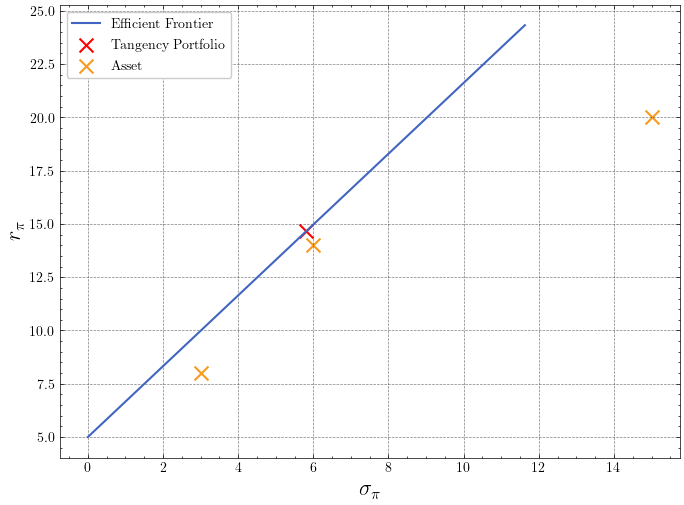

In [22]:
plt.figure(figsize=(8, 6), dpi=100)
save_name='./short_sales_and_borrowing_allowed.png'
efficient_frontier.plot_frontier(allow_shorts=True, allow_lending=True, returns=μ, stds=stds, riskless_rate=R_f, save_name=save_name)

## Short Sales Allowed: No Riskless Lending and Borrowing

Whenever an investor can't lend/borrow at the riskless rate the following section must be modified. However, much of the analysis carries over. The efficient set constructed before allowed us to calculate the tendency portfolio which lies on the efficient set at the point where lending/borrowing is zero. Therefore we can assume different risk-free rates and find various tangency portfolios. 

If we were to proceed with this approach we would have to calculate n portfolio weights, one for each point we wish to plot on the efficient frontier. If we have lots of securities, N then the $\mathcal{O}(N^3)$  computational complexity of solving the system of linear equations for each point will become an issue.

We in fact only need two portfolios summary statistics along with the covariance between them to trace out the entire efficient set. We can find the covariance between the two portfolios by simply solving for $\sigma_{ab}$ in the standard definition of the variance of two risky assets.

<Figure size 800x600 with 0 Axes>

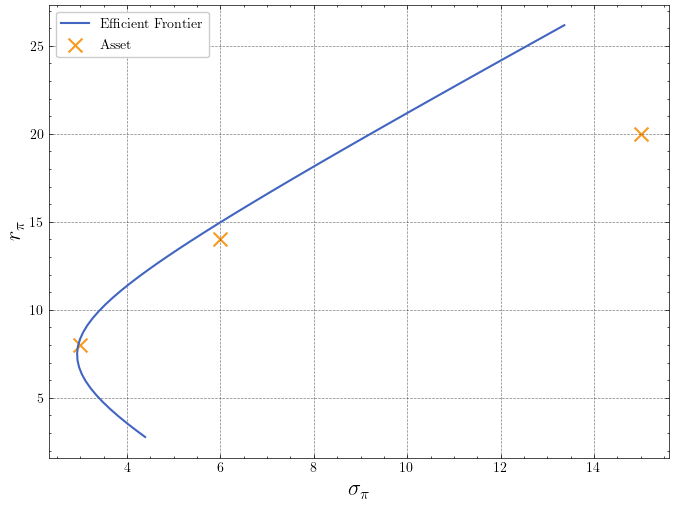

In [39]:
plt.figure(figsize=(8, 6), dpi=100)
save_name='short_sales_alowed.png'
efficient_frontier.plot_frontier(allow_shorts=True, allow_lending=False, returns=μ, stds=stds, save_name=save_name)

# Riskless Lending and Borrowing with Short Sales Not Allowed

As with the fully unconstrained case, there exists a single portfolio that is optimal. Again it is the portfolio that maximises the excess returns over the portfolio volatility. 

The difference now is that we must include the additional constraint that all security weights must be grate than or equal to zero. Formally we can state the problem as 

**Maximise**

$$ \frac{x^T\mu - r_f}{\sqrt{x^T\Sigma x}} $$

**Subject to**

$$ \sum_{i=1}^{N} x_i = 1 $$

$$x_i \geq 0$$


The nature of the objective makes this problem difficult. However, with a reasonable simplifying assumption the problem can be reduced to a standard convex quadratic program. The assumption is that a portfolio exists that can beat the risk-free rate of return and it can be expressed mathematically as.

$$\mu^T x - r_f > 0$$

Using a similar tactic as before we can massage the original objective 

$$f(x) = \frac{x^T\mu - r_f}{\sqrt{x^T\Sigma x}} =  \frac{x^T\mu - r_f\sum_{i=1}^Nx_i}{\sqrt{x^T\Sigma x}} = \frac{\hat{\mu}^Tx}{\sqrt{x^T\Sigma x}} $$

Now notice that $f(\lambda x) = f(x)$ due to the fact any scalar multiplication of x will cancel in numerator and denominator.


**Minimize**

$$ y^T \Sigma y $$

**Subject to**

$$ (\mu - r_F)^T y = 1 $$

$$\hat{A} y \geq 0$$

$$ 0 \leq y$$

<Figure size 800x600 with 0 Axes>

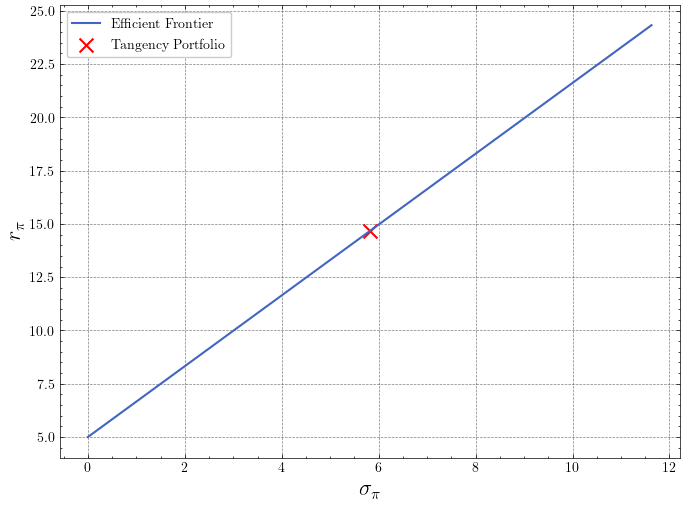

In [76]:
plt.figure(figsize=(8, 6), dpi=100)
save_name='no_short_sales_riskless_lending'
efficient_frontier.plot_frontier(allow_shorts=False, allow_lending=True, riskless_rate=5, save_name=save_name)

## No Short Selling and No Riskless Lending and Borrowing

The efficient set is found by minimising the risk level for a given level of expected return. Therfore, one can specify the return at some level and minimize the risk, obtaining a single point on the efficient frontier. We can fromalize this by saying we seek to 

**Minimize**

$$ x^T\Sigma x $$

**Subject to**

$$ \sum_{i=1}^N x_i = 1$$

$$ \sum_{i=1}^N x_i \mu = \bar{r}_{\pi}$$

$$ x_i \geq 0$$

This convex optimisation problem has an objective function that is easily solved by packages such a cvxopt.

<Figure size 800x600 with 0 Axes>

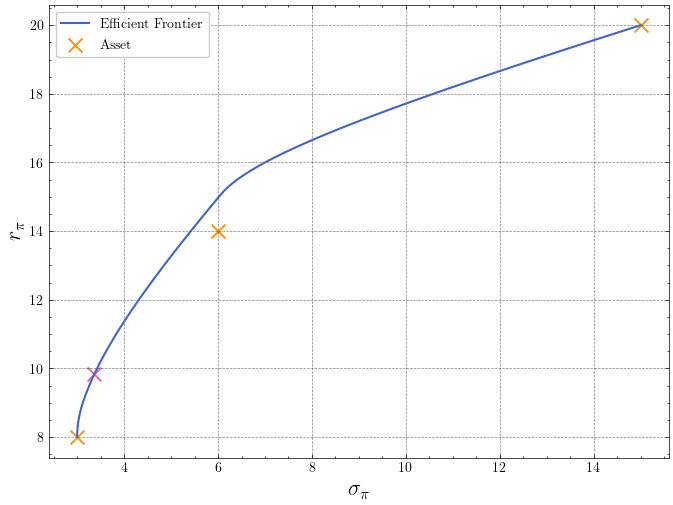

array([[2.92046238]])

In [60]:
plt.figure(figsize=(8, 6), dpi=100)
save_name='no_short_sales_no_riskless_lending'
efficient_frontier.plot_frontier(allow_shorts=False, allow_lending=False, riskless_rate=5, save_name=save_name)

In [89]:
"['ADI','MDLZ','CDW','BIIB','IDXX','XEL','PDD','ASML','DOCU','JD','CHTR','SBUX','BKNG','INCY','AAPL','FAST','CSCO','TCOM','MAR','INTC','MTCH','MELI','CDNS','CERN','DXCM','MRVL','CPRT','KDP','CHKP','QCOM','AMZN','XLNX','PTON','ILMN','CMCSA','GOOG','ALXN','MNST','EXC','MSFT','BIDU','FISV','WBA','SPLK','KHC','OKTA','GILD','PEP','MRNA','DLTR']".replace('\'','')

'[ADI,MDLZ,CDW,BIIB,IDXX,XEL,PDD,ASML,DOCU,JD,CHTR,SBUX,BKNG,INCY,AAPL,FAST,CSCO,TCOM,MAR,INTC,MTCH,MELI,CDNS,CERN,DXCM,MRVL,CPRT,KDP,CHKP,QCOM,AMZN,XLNX,PTON,ILMN,CMCSA,GOOG,ALXN,MNST,EXC,MSFT,BIDU,FISV,WBA,SPLK,KHC,OKTA,GILD,PEP,MRNA,DLTR]'